In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import mir_eval
import scipy
import librosa
import tqdm
import copy
import glob

import models
import datasets
import oracles
import metrics
import utils
import change_point_detection as cpd
import query_strategies as qs
import evaluate
import visualize

import metrics

import matplotlib.pyplot as plt
import matplotlib
import config

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [ ]:
datasets_dir = '/mnt/storage_1/john/data/bioacoustic_sed_2024_02_22/generated_datasets'
class_name = 'baby'
strategy_names = ['ADP', 'FIX'] #, 'CPD', 'FIX']
idx_run = 0
for idx_soundscape in np.random.randint(0, 300, 10):

    for n_queries in [30]:
        n_rows = len(strategy_names)
        fig, ax = plt.subplots(n_rows, 1, figsize=(15, 5))
        for idx_row, strategy_name in enumerate(strategy_names):

            soundscape_basename = 'soundscape_{}'.format(idx_soundscape)
            sim_dir = '../results/default/{}/n_queries_{}_noise_0.0_prominence_threshold_0.1_coverage_threshold_0.99/'.format(class_name, n_queries)
            pred_dir  = os.path.join(sim_dir, strategy_name, str(idx_run), 'train_annotations')
            truth_dir = os.path.join(datasets_dir, '{}_1.0_0.25s/train_soundscapes_snr_0.0/'.format(class_name))
        
            visualize.plot_soundscape(datasets_dir, pred_dir, truth_dir, soundscape_basename, ax[idx_row])
            ax[idx_row].set_title('soundscape: {}, class: {}, n_queries: {}, method: {}'.format(soundscape_basename, class_name, n_queries, strategy_name))
        plt.tight_layout()
        plt.show()

In [ ]:
pwd

In [3]:
# 1. load query strategy with given sample budget as in evaluation
emb_win_length = 1.0
class_name = 'baby'
idx_run = 0
only_budget_1 = True
strategy_name = 'ADP'
model_name = 'prototypical'

# 2 second window
# base_dir = '/mnt/storage_1/john/data/bioacoustic_sed/'
# sim_dir = '/mnt/storage_1/john/al_for_sed_results/2024-02-15/{}/n_queries_7_noise_0.0_prominence_threshold_0.0_coverage_threshold_0.5/'.format(class_name)

# 1 second window
base_dir = '/mnt/storage_1/john/data/bioacoustic_sed_2024_02_22/'
sim_dir = '../results/test-2024-02-23/{}/n_queries_7_noise_0.0_prominence_threshold_0.0_coverage_threshold_0.5/'.format(class_name)

# ADP
conf = config.Config()
conf.strategy_name = strategy_name
adp_model = models.AdaptiveQueryStrategy(conf)

emb_win_length = emb_win_length
emb_hop_length = emb_win_length / 4

emb_hop_length_str = '{:.2f}'.format(emb_hop_length)
emb_win_length_str = '{:.1f}'.format(emb_win_length)
class_name = class_name

train_base_dir = '{}/generated_datasets/{}_{}_{}s/train_soundscapes_snr_0.0'.format(base_dir, class_name, emb_win_length_str, emb_hop_length_str)

train_annotation_dir   = os.path.join(sim_dir, strategy_name, str(idx_run), 'train_annotations')
print(train_annotation_dir)

# load train annotations
train_annotation_paths = glob.glob(os.path.join(train_annotation_dir, "*.tsv"))

def get_iteration(fp):
    return int(os.path.basename(fp).split('_')[1])

def get_soundscape_basename(fp):
    return "_".join(os.path.basename(fp).split('_')[2:]).split('.')[0]

if only_budget_1:
    evaluation_budgets = [1.0]
else:
    evaluation_budgets = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.0]

# TODO: something goes wrong here with budget 1.0, max over empty list
# the problem is most likely solved, the n_runs were inconsistent with the number of runs in the sim_dir
n_soundscapes      = np.max([get_iteration(fp) for fp in train_annotation_paths]) + 1
n_iters            = [int(evaluation_budget * n_soundscapes) for evaluation_budget in evaluation_budgets]

for idx_budget, n_iter in enumerate(n_iters):
    sys.stdout.write("strategy = {}, run = {}, model_name = {}, budget = {}, n_iter = {}\n".format(strategy_name, idx_run, model_name, evaluation_budgets[idx_budget], n_iter))
    # 1. load the annotations until n_iter
    budget_train_annotation_paths = [fp for fp in train_annotation_paths if get_iteration(fp) < n_iter]
    assert len(budget_train_annotation_paths) == n_iter, "budget not respected, expected {}, got {}".format(n_iter, len(budget_train_annotation_paths))
    soundscape_basenames          = [get_soundscape_basename(fp) for fp in budget_train_annotation_paths]

    # 2. load embeddings and annotations for current budget
    p_embss   = []
    n_embss   = []
    for idx, soundscape_basename in enumerate(soundscape_basenames):

        #pos_ann = np.load(budget_train_annotation_paths[idx])
        pos_ann = evaluate.get_positive_annotations(budget_train_annotation_paths[idx])
        p_embs, n_embs, _ = evaluate.get_embeddings_3(pos_ann, train_base_dir, soundscape_basename, emb_win_length)
        p_embs = np.array(p_embs)
        n_embs = np.array(n_embs)

        p_embss.append(p_embs)
        n_embss.append(n_embs)

    # positive and negative embeddings
    p_embs = np.concatenate(p_embss)
    n_embs = np.concatenate(n_embss)

    # TODO: batch normalization of embeddings in MLP seems to improve performance a lot,
    # is it possible that the embeddings are not normalized correctly?
    #print("mean p_embs: ", np.mean(p_embs, axis=0))
    #print("std p_embs: ",  np.std(p_embs, axis=0))
    
    # # 3. train the model using the annotated embeddings
    # if model_name == 'prototypical':
    #     # NOTE: we only use the predictive model, never the queries, i.e, the query strategies do not matter here
    #     # model = models.AdaptiveQueryStrategy(conf) #train_base_dir, random_soundscape=False, fixed_queries=False, emb_cpd=False, normal_prototypes=True)
    #     # update the model with the annotated data
    #     adp_model.update(p_embs, n_embs)


../results/test-2024-02-23/baby/n_queries_7_noise_0.0_prominence_threshold_0.0_coverage_threshold_0.5/ADP/0/train_annotations
strategy = ADP, run = 0, model_name = prototypical, budget = 1.0, n_iter = 300


method = ADP, n_queries = 7
(128, 646)
method = CPD, n_queries = 7
(128, 646)
method = FIX, n_queries = 7
(128, 646)
method = Opt., n_queries = 7
(128, 646)
method = Sub., n_queries = 7
(128, 646)


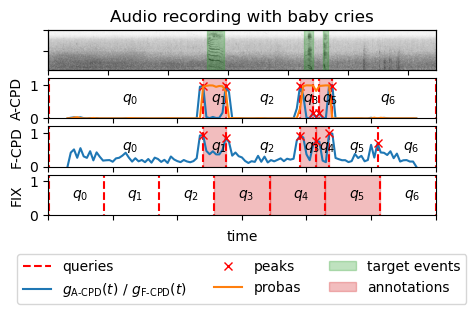

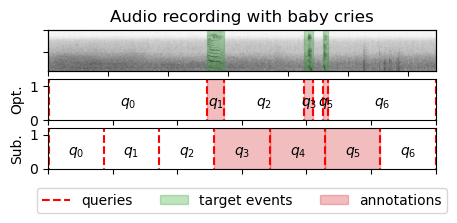

In [36]:
# CPD
conf = config.Config()
conf.strategy_name = 'CPD'
cpd_model = models.AdaptiveQueryStrategy(conf)

# OPT
conf = config.Config()
conf.strategy_name = 'OPT'
opt_model = models.AdaptiveQueryStrategy(conf)

# FIX
conf = config.Config()
conf.strategy_name = 'FIX'
fix_model = models.AdaptiveQueryStrategy(conf)

# ADP
conf = config.Config()
conf.strategy_name = 'ADP'
adp_model = models.AdaptiveQueryStrategy(conf)
adp_model.update(p_embs, n_embs)

test_base_dir = train_base_dir.replace('train', 'test')

new_query_strategy_names = ['A-CPD', 'F-CPD', 'FIX']

for soundscape_number in range(1, 2):
    visualize.visualize_query_strategies(
        [adp_model, cpd_model, fix_model],
        ["ADP", "CPD", "FIX"], #, "FIX"],
        new_query_strategy_names,
        #"FIX, max_n_queries = {}".format(n_queries),
        "soundscape_{}".format(soundscape_number),
        test_base_dir,
        n_queries     = 7,
        savefile      = '../figures/examples_Ls=1.0/soundscape_{}.png'.format(soundscape_number),
        noise_factor  = 0,
        normalize     = False,
        coverage_threshold=0.5,
        prominence_threshold=0,
    )

    visualize.visualize_concept(
        [opt_model, fix_model],
        ["Opt.", "Sub."], #, "FIX"],
        #"FIX, max_n_queries = {}".format(n_queries),
        "soundscape_{}".format(soundscape_number),
        test_base_dir,
        n_queries     = 7,
        savefile      = '../figures/examples_Ls=1.0/concept_{}.png'.format(soundscape_number),
        noise_factor  = 0,
        normalize     = False,
        coverage_threshold=0.5,
        prominence_threshold=0,
    )


In [ ]:

# 2. visualize the query strategy for some test data
test_base_dir = train_base_dir #train_base_dir.replace('train', 'test')
test_soundscape_basename = 'soundscape_190'
n_queries = 7

vis_queries=True
vis_peaks=False
vis_cpd=False
vis_label=True
vis_ent=True
vis_probs=True
coverage_threshold=0.5 #0.05
prominence_threshold=0.0

# ADP
print("test_base_dir: ", test_base_dir)
visualize.visualize_query_strategy(
    adp_model,
    "ADP, max_n_queries = {}".format(n_queries),
    test_soundscape_basename,
    test_base_dir,
    n_queries,
    vis_true      = True,
    vis_probs     = vis_probs,
    vis_queries   = vis_queries,
    vis_label     = vis_label,
    vis_threshold = False,
    vis_cpd       = vis_cpd,
    vis_peaks     = vis_peaks,
    vis_embs_label= False,
    vis_ent       = vis_ent,
    savefile      = None,
    noise_factor  = 0,
    normalize     = False,
    coverage_threshold=coverage_threshold,
    prominence_threshold=prominence_threshold,
)

# # CPD
conf = config.Config()
conf.strategy_name = 'CPD'
cpd_model = models.AdaptiveQueryStrategy(conf)
print("test_base_dir: ", test_base_dir)
visualize.visualize_query_strategy(
    cpd_model,
    "CPD, max_n_queries = {}".format(n_queries),
    test_soundscape_basename,
    test_base_dir,
    n_queries,
    vis_true      = True,
    vis_probs     = vis_probs,
    vis_queries   = vis_queries,
    vis_label     = vis_label,
    vis_threshold = False,
    vis_cpd       = vis_cpd,
    vis_peaks     = vis_peaks,
    vis_embs_label= False,
    savefile      = None,
    noise_factor  = 0,
    normalize     = False,
    coverage_threshold=coverage_threshold,
    prominence_threshold=prominence_threshold,
)
# FIX
conf = config.Config()
conf.strategy_name = 'FIX'
fix_model = models.AdaptiveQueryStrategy(conf)
print("test_base_dir: ", test_base_dir)
visualize.visualize_query_strategy(
    fix_model,
    "FIX, max_n_queries = {}".format(n_queries),
    test_soundscape_basename,
    test_base_dir,
    n_queries,
    vis_true      = True,
    vis_probs     = vis_probs,
    vis_queries   = vis_queries,
    vis_label     = vis_label,
    vis_threshold = False,
    vis_cpd       = False,
    vis_peaks     = False,
    vis_embs_label= False,
    savefile      = None,
    noise_factor  = 0,
    normalize     = False,
    coverage_threshold=coverage_threshold,
    prominence_threshold=prominence_threshold,
)




# results are saved as
# np.save(os.path.join(sim_dir, '{}_{}_f1_event_based_train_results.npy'.format(model_name, method_name)), f1_event_based_train_results)
# np.save(os.path.join(sim_dir, '{}_{}_f1_segment_based_train_results.npy'.format(model_name, method_name)), f1_segment_based_train_results)
# np.save(os.path.join(sim_dir, '{}_{}_f1_event_based_test_results.npy'.format(model_name, method_name)), f1_event_based_test_results)
# np.save(os.path.join(sim_dir, '{}_{}_f1_segment_based_test_results.npy'.format(model_name, method_name)), f1_segment_based_test_results)
#
# produce figure loads the results for each model_name and method_name and plots f1_event_based_train results in one plot, f1_segment_based_train results in another plot, f1_event_based_test results in another plot, and f1_segment_based_test results in another plot.
# method_name and model_name are part of the legend in the plot


In [ ]:
def list_difference(l1, l2):
    return list(set(l1).difference(l2))

In [ ]:
snr = '0.0'

# example 3, 0.8 second window, 0.25 second hop length
# Meerkat
base_dir = '/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/me_0.8s_0.20s_large_final/train_soundscapes_snr_{}/'.format(snr)
test_base_dir = '/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/me_0.8s_0.20s_large_final/test_soundscapes_snr_{}/'.format(snr)

# Dog
# base_dir = '/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/dog_1.0s_0.25s_large_final/train_soundscapes_snr_{}/'.format(snr)
# test_base_dir = '/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/dog_1.0s_0.25s_large_final/test_soundscapes_snr_{}/'.format(snr)

# Baby

## Rectangular
#base_dir = '/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/baby_1.0s_0.25s_rect_large_final/train_soundscapes_snr_{}/'.format(snr)
#test_base_dir = '/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/baby_1.0s_0.25s_rect_large_final/test_soundscapes_snr_{}/'.format(snr)

## Gaussian
# base_dir = '/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/baby_1.0s_0.25s_large_final/train_soundscapes_snr_{}/'.format(snr)
# test_base_dir = '/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/baby_1.0s_0.25s_large_final/test_soundscapes_snr_{}/'.format(snr)


n_soundscapes = 100

# normal_prototypes = True
# query_strategy_1 = models.AdaptiveQueryStrategy(base_dir, random_soundscape=True,  fixed_queries=False, emb_cpd=False, normal_prototypes=normal_prototypes)
# query_strategy_2 = models.AdaptiveQueryStrategy(base_dir, random_soundscape=True,  fixed_queries=True, emb_cpd=True,  normal_prototypes=normal_prototypes)
# query_strategy_3 = models.AdaptiveQueryStrategy(base_dir, random_soundscape=True,  fixed_queries=True,  emb_cpd=False, normal_prototypes=normal_prototypes)

all_soundscape_basenames = ['soundscape_{}'.format(idx) for idx in range(n_soundscapes)]

remaining_soundscape_basenames = all_soundscape_basenames
remaining_soundscape_basenames = sorted(remaining_soundscape_basenames)


#query_strategies = [None, query_strategy_1, query_strategy_2, query_strategy_3]

#test_soundscape_basename = 'soundscape_10'
test_soundscape_basename = 'soundscape_18'
#test_soundscape_basename = 'soundscape_45' # interesting failure case, think about
#test_soundscape_basename = 'soundscape_19'
#test_soundscape_basename = 'soundscape_20'

noise_factor = 0.0
n_queries = 7

visualize.visualize_query_strategy(
    query_strategy_0,
    "Optimal queries",
    test_soundscape_basename,
    test_base_dir,
    n_queries,
    vis_true      = True,
    vis_probs     = True,
    vis_queries   = False,
    vis_label     = False,
    vis_threshold = True,
    vis_cpd       = False,
    vis_peaks     = False,
    vis_embs_label= False,
    savefile      = None,
    noise_factor  = noise_factor,
    normalize     = False,
)

visualize.visualize_query_strategy(
    query_strategy_1,
    "Adaptive queries",
    test_soundscape_basename,
    test_base_dir,
    n_queries,
    vis_true      = True,
    vis_probs     = True,
    vis_queries   = False,
    vis_label     = False,
    vis_threshold = True,
    vis_cpd       = False,
    vis_peaks     = False,
    vis_embs_label= False,
    savefile      = None,
    noise_factor  = noise_factor,
    normalize     = False,
)

visualize.visualize_query_strategy(
    query_strategy_2,
    "CPD queries",
    test_soundscape_basename,
    test_base_dir,
    n_queries,
    vis_true      = True,
    vis_probs     = True,
    vis_queries   = False,
    vis_label     = False,
    vis_threshold = True,
    vis_cpd       = False,
    vis_peaks     = False,
    vis_embs_label= False,
    savefile      = None,
    noise_factor  = noise_factor,
    normalize     = False,
)


visualize.visualize_query_strategy(
    query_strategy_3,
    "Fixed queries",
    test_soundscape_basename,
    test_base_dir,
    n_queries,
    vis_true      = True,
    vis_probs     = True,
    vis_queries   = False,
    vis_label     = False,
    vis_threshold = True,
    vis_cpd       = False,
    vis_peaks     = False,
    vis_embs_label= False,
    savefile      = None,
    noise_factor  = noise_factor,
    normalize     = False,
)

# Debugging the active loop

In [ ]:
from run_simulation import simulate_strategy, list_difference
from evaluate import evaluate_model_on_test_data, evaluate_annotation_process_on_test_data

In [ ]:
snr = '0.0'
emb_win_length = 1.0

class_name = 'baby'
base_dir      = '/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/{}_1.0_0.25s/train_soundscapes_snr_{}/'.format(class_name, snr)
test_base_dir = base_dir.replace('train', 'test')


n_soundscapes = 200

normal_prototypes    = True
normalize_embeddings = True
fp_noise = 0.0
fn_noise = 0.0


strategy_names = ['OPT', 'ADP', 'CPD', 'FIX']



indices_query_strategies = [0, 1, 2, 3]
n_queries = 7

min_iou = 0.000001

noise_factor = 0
test_soundscape_basename = 'soundscape_0'

n_soundscapes_budget = 60
n_eval = 10
n_runs = 1 #20

f1_scores_test     = np.zeros((4, n_runs, 1, n_soundscapes_budget // n_eval))
miou_scores_test   = np.zeros((4, n_runs, 1, n_soundscapes_budget // n_eval))
f1_scores_train    = np.zeros((4, n_runs, 1, n_soundscapes_budget // n_eval))
miou_scores_train  = np.zeros((4, n_runs, 1, n_soundscapes_budget // n_eval))


f1_scores_train_online   = np.zeros((4, n_runs, 1, n_soundscapes_budget))
miou_scores_train_online = np.zeros((4, n_runs, 1, n_soundscapes_budget))

print("normal prototypes    = ", normal_prototypes)
print("normalize embeddings = ", normalize_embeddings)

#dx_n_queries = 0
idx_init = 0

for idx_run in range(n_runs):
    # initalize methods
    query_strategy_0 = models.AdaptiveQueryStrategy(base_dir, random_soundscape=True,  opt_queries=True, fixed_queries=False, emb_cpd=False, normal_prototypes=normal_prototypes)
    query_strategy_1 = models.AdaptiveQueryStrategy(base_dir, random_soundscape=True,  fixed_queries=False, emb_cpd=False, normal_prototypes=normal_prototypes)
    query_strategy_2 = models.AdaptiveQueryStrategy(base_dir, random_soundscape=True,  fixed_queries=True,  emb_cpd=True,  normal_prototypes=normal_prototypes)
    query_strategy_3 = models.AdaptiveQueryStrategy(base_dir, random_soundscape=True,  fixed_queries=True,  emb_cpd=False, normal_prototypes=normal_prototypes)
    query_strategies = [query_strategy_0, query_strategy_1, query_strategy_2, query_strategy_3]
    
    # initial unlabeled soundscapes
    all_soundscape_basenames = ['soundscape_{}'.format(idx) for idx in range(n_soundscapes)]
    remaining_soundscape_basenames = all_soundscape_basenames
    remaining_soundscape_basenames = sorted(remaining_soundscape_basenames)

    bnss = []
    for _ in range(len(query_strategies)):
        bnss.append(copy.copy(remaining_soundscape_basenames))  
  
    budget_count = 0
    print("####################################################")
    print("Run: {}".format(idx_run))
    print("####################################################")

    while budget_count < n_soundscapes_budget:
        print("----------------------------------------")
        #print("iteration {}".format(budget_count))
        for idx_query_strategy in indices_query_strategies: 
            query_strategy = query_strategies[idx_query_strategy]

            if budget_count % n_eval == 0:
                f1_test_score, miou_test_score   = evaluate_model_on_test_data(query_strategy, test_base_dir)
                f1_train_score, miou_train_score = evaluate_annotation_process_on_test_data(query_strategy, test_base_dir, n_queries, noise_factor)

                f1_scores_train[idx_query_strategy, idx_run, idx_init, budget_count//n_eval] = f1_train_score
                miou_scores_train[idx_query_strategy, idx_run, idx_init, budget_count//n_eval] = miou_train_score

                f1_scores_test[idx_query_strategy, idx_run, idx_init, budget_count//n_eval] = f1_test_score
                miou_scores_test[idx_query_strategy, idx_run, idx_init, budget_count//n_eval] = miou_test_score

                #print("-------------------------------------")
                print("strategy {}, iteration {}, f1 = {:.3f}, miou = {:.3f} (train)".format(strategy_names[idx_query_strategy], budget_count, f1_train_score, miou_train_score))
                print("strategy {}, iteration {}, f1 = {:.3f}, miou = {:.3f} (test)".format(strategy_names[idx_query_strategy], budget_count, f1_test_score, miou_test_score))

                # save prediction probas on test file to disk
                figure_dir_path = os.path.join('figures/debugging/n_queries_{}/strategy_{}/'.format(n_queries, idx_query_strategy))
                if not os.path.exists(figure_dir_path):
                    os.makedirs(figure_dir_path)

                visualize.visualize_query_strategy(
                    query_strategy,
                    "spent budget = {}, strategy = {}".format(budget_count, strategy_names[idx_query_strategy]),
                    test_soundscape_basename,
                    test_base_dir,
                    n_queries,
                    vis_probs     = True,
                    vis_queries   = True,
                    vis_label     = False,
                    vis_threshold = True,
                    vis_cpd       = True,
                    vis_peaks     = True,
                    savefile=os.path.join(figure_dir_path, "iteration_{}.png".format(budget_count)),
                    fp_noise=fp_noise,
                    fn_noise=fn_noise,
                )

            bns = bnss[idx_query_strategy]

            f1_train, miou_train, _, _, bns, _ = simulate_strategy(
                query_strategy       = query_strategy,
                soundscape_basenames = bns,
                n_queries            = n_queries,
                base_dir             = base_dir,
                min_iou              = min_iou,
                noise_factor         = noise_factor,
                normalize            = normalize_embeddings,
                iteration            = budget_count,
                emb_win_length       = emb_win_length,
                fp_noise             = fp_noise,
                fn_noise             = fn_noise,
            )
            f1_scores_train_online[idx_query_strategy, idx_run, idx_init, budget_count] = f1_train
            miou_scores_train_online[idx_query_strategy, idx_run, idx_init, budget_count] = miou_train
            #print("simulation time: ", time.time() - t1)
            bnss[idx_query_strategy] = bns
            #print("strategy {}: ".format(idx_query_strategy), bns)

            #print("strategy {}, iteration {}, f1 = {:.2f}, miou = {:.2f} (train)".format(idx_query_strategy, budget_count, f1_train_score, miou_train_score))

        # increase budget count
        budget_count += 1


In [ ]:
strategy_names = ['none', 'ADP', 'CPD', 'FIX']
print("    & f1                   & miou")
for idx_query_strategy in indices_query_strategies:
    f1_mean = f1_scores_train_online[idx_query_strategy].mean()
    f1_std  = f1_scores_train_online[idx_query_strategy].std()
    miou_mean = miou_scores_train_online[idx_query_strategy].mean()
    miou_std  = miou_scores_train_online[idx_query_strategy].std()

    print("{} & ${:.3f} \pm {:.3f}$ &  ${:.3f} \pm {:.3f}$".format(
        strategy_names[idx_query_strategy], f1_mean, f1_std, miou_mean, miou_std))

In [ ]:
fig, ax = plt.subplots(1, 2)
for idx_strategy in [1, 2, 3]: #[0, 1, 2, 3]: #range(4):
    mean_mious = miou_scores_test[idx_strategy].mean(axis=(0, 1))
    mean_f1s   = f1_scores_test[idx_strategy].mean(axis=(0, 1))

    # label quality of training data
    #mean_mious_train = miou_scores_train[idx_strategy, idx_n_queries].mean(axis=0)
    #mean_f1s_train   = f1_scores_train[idx_strategy, idx_n_queries].mean(axis=0)
    
    ax[0].plot(mean_mious, label=strategy_names[idx_strategy], color=colors[idx_strategy])
    #ax[0].plot(mean_mious_train, label=strategy_names[idx_strategy] + ' (train)', color=colors[idx_strategy], linestyle='dashed')
    ax[0].set_xlabel('Annotated batches of soundscapes')
    ax[0].set_ylabel('miou')
    ax[0].legend(loc='lower right')
    ax[0].set_ylim([0, 1.05])
    
    ax[1].plot(mean_f1s, label=strategy_names[idx_strategy], color=colors[idx_strategy])
    #ax[1].plot(mean_f1s_train, label=strategy_names[idx_strategy] + ' (train)', color=colors[idx_strategy], linestyle='dashed')
    ax[1].set_xlabel('Annotated batches of soundscapes')
    ax[1].set_ylabel('F1')
    ax[1].legend(loc='lower right')
    ax[1].set_ylim([0, 1.05])

plt.suptitle('Model performance on test data')
plt.tight_layout()

In [ ]:
strategy_names = ['none', 'ADP', 'CPD', 'FIX']

fig, ax = plt.subplots(1, 2)
for idx_strategy in [1, 2, 3]: #[0, 1, 2, 3]: #range(4):
    mean_mious = miou_scores_train[idx_strategy].mean(axis=(0, 1))
    mean_f1s   = f1_scores_train[idx_strategy].mean(axis=(0, 1))
    
    ax[0].plot(mean_mious, label=strategy_names[idx_strategy], color=colors[idx_strategy])
    ax[0].set_xlabel('Annotated batches of soundscapes')
    ax[0].set_ylabel('miou')
    ax[0].legend()
    #ax[0].set_ylim([0.2, 0.4])
    
    ax[1].plot(mean_f1s, label=strategy_names[idx_strategy], color=colors[idx_strategy])
    ax[1].set_xlabel('Annotated batches of soundscapes')
    ax[1].set_ylabel('F1')
    ax[1].legend()

plt.suptitle('Annotation quality on test data')
plt.tight_layout()


# saved annotations

In [ ]:
train_annotation_dir = '../results/me_0.8/train_annotations/'

In [ ]:
for strategy_name in ['OPT','ADP']:
    print("############################################")
    print(strategy_name)
    print("############################################")
    train_base_dir = '/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/me_0.8s_0.20s_rect_large_final/train_soundscapes_snr_{}/'.format(snr)
    ann_files = glob.glob(os.path.join(train_annotation_dir, strategy_name, '0', '*.npy'))

    for ann_file in ann_files[:10]:
        #print(ann_file)
        pos_ann = np.load(ann_file)
        soundscape_basename = os.path.basename(ann_file).split('.')[0]
        print(soundscape_basename, ["({:.2f}, {:.2f})".format(s, e) for (s, e) in pos_ann])

# pseudo-probability distributions

In [ ]:
import seaborn as sns
# TODO: visualize positive and negative separately

In [ ]:
proba_dir = os.path.join(base_dir, "probas")
proba_paths = sorted(glob.glob(os.path.join(proba_dir, "*.npy")))

for proba_path in proba_paths[:10]:
    basename = os.path.basename(proba_path)
    iteration = int(basename.split('_')[0])

    if iteration % 1 == 0:
        print(proba_path)
        probas = np.load(proba_path)
        fig = plt.figure()
        sns.histplot(probas, stat='probability', bins=20)
        plt.show()

In [ ]:
n_prototype = np.random.randn(1024)
p_prototype = np.random.randn(1024)

In [ ]:
# Diff. invariance to semantics?
normal_prototypes = True
query_strategy = models.AdaptiveQueryStrategy(base_dir, random_soundscape=True,  fixed_queries=False, emb_cpd=False, normal_prototypes=normal_prototypes)

query_strategy.n_prototype = n_prototype
query_strategy.p_prototype = p_prototype

visualize.visualize_query_strategy(
    query_strategy,
    "ADP",
    test_soundscape_basename,
    test_base_dir,
    n_queries,
    vis_probs     = True,
    vis_queries   = False,
    vis_label     = False,
    vis_threshold = False,
    vis_cpd       = True,
    vis_peaks     = False,
    savefile      = None,
    noise_factor  = noise_factor,
    normalize     = False,
)

query_strategy.n_prototype = p_prototype
query_strategy.p_prototype = n_prototype

visualize.visualize_query_strategy(
    query_strategy,
    "ADP",
    test_soundscape_basename,
    test_base_dir,
    n_queries,
    vis_probs     = True,
    vis_queries   = False,
    vis_label     = False,
    vis_threshold = False,
    vis_cpd       = True,
    vis_peaks     = False,
    savefile      = None,
    noise_factor  = noise_factor,
    normalize     = False,
)

In [ ]:
N = 10
for soundscape_basename in all_soundscape_basenames[:N]:

    presentation_dir = 'presentation'
    if not os.path.exists(presentation_dir):
        os.makedirs(presentation_dir)
    
    figure_name = 'adaptive_labels_{}.png'.format(soundscape_basename)
    savefile    = os.path.join(presentation_dir, figure_name)
    
    visualize.visualize_query_strategy(
        query_strategy_1,
        "Adaptive queries",
        soundscape_basename,
        test_base_dir,
        n_queries,
        vis_probs     = False,
        vis_queries   = True,
        vis_label     = True,
        vis_threshold = False,
        vis_cpd       = False,
        vis_peaks     = False,
        savefile=savefile,
    )

for soundscape_basename in remaining_soundscape_basenames[:N]:

    presentation_dir = 'presentation'
    if not os.path.exists(presentation_dir):
        os.makedirs(presentation_dir)
    
    figure_name = 'fixed_labels_{}.png'.format(soundscape_basename)
    savefile    = os.path.join(presentation_dir, figure_name)
    
    visualize.visualize_query_strategy(
        query_strategy_3,
        "Fixed queries",
        soundscape_basename,
        test_base_dir,
        n_queries,
        vis_probs     = False,
        vis_queries   = True,
        vis_label     = True,
        vis_threshold = False,
        vis_cpd       = False,
        vis_peaks     = False,
        savefile=savefile,
    )

# Do we fail gracefully?

In [ ]:
snr = '0.0'

# example 3, 0.8 second window, 0.25 second hop length
base_dir = '/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/me_0.8s_0.25s_large/train_soundscapes_snr_{}/'.format(snr)
test_base_dir = '/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/me_0.8s_0.25s_large/test_soundscapes_snr_{}/'.format(snr)

n_soundscapes = 30

query_strategy_1 = models.AdaptiveQueryStrategy(base_dir, random_soundscape=True,  fixed_queries=False)
query_strategy_3 = models.AdaptiveQueryStrategy(base_dir, random_soundscape=True,  fixed_queries=True)

all_soundscape_basenames = ['soundscape_{}'.format(idx) for idx in range(n_soundscapes)]
init_idx = 0
init_soundscape_basename = all_soundscape_basenames[init_idx]

print(init_soundscape_basename)

# initialize strategies with ground truth labels for supplied soundscape
query_strategy_1.initialize_with_ground_truth_labels(init_soundscape_basename)
query_strategy_3.initialize_with_ground_truth_labels(init_soundscape_basename)

remaining_soundscape_basenames = list_difference(all_soundscape_basenames, [init_soundscape_basename])
remaining_soundscape_basenames = sorted(remaining_soundscape_basenames)

# add noise
soundscape_basename = remaining_soundscape_basenames[6]
n_queries = 30

for soundscape_basename in remaining_soundscape_basenames:
    for noise_factor in [0]: #, 0.5, 1, 2]:
        visualize.visualize_query_strategy(
            query_strategy_1,
            "Adaptive queries (noise = {})".format(noise_factor),
            soundscape_basename,
            base_dir,
            n_queries,
            vis_probs     = True,
            vis_queries   = True,
            vis_label     = True,
            vis_threshold = False,
            vis_cpd       = False,
            vis_peaks     = False,
            savefile      = None,
            noise_factor  = noise_factor
        )
        visualize.visualize_query_strategy(
            query_strategy_3,
            "Fixed queries (noise = {})".format(noise_factor),
            soundscape_basename,
            base_dir,
            n_queries,
            vis_probs     = False,
            vis_queries   = True,
            vis_label     = True,
            vis_threshold = False,
            vis_cpd       = False,
            vis_peaks     = False,
            savefile      = None,
            noise_factor  = noise_factor
        )

# Presentation figures

In [ ]:
soundscape_basename = remaining_soundscape_basenames[6]
n_queries = 7

presentation_dir = 'presentation'
if not os.path.exists(presentation_dir):
    os.makedirs(presentation_dir)

figure_name = 'fixed_0.png'
savefile    = os.path.join(presentation_dir, figure_name)

visualize.visualize_query_strategy(
    query_strategy_3,
    "Fixed queries",
    soundscape_basename,
    base_dir,
    n_queries,
    vis_probs     = False,
    vis_queries   = False,
    vis_label     = False,
    vis_threshold = False,
    vis_cpd       = False,
    vis_peaks     = False,
    savefile      = savefile,
)

In [ ]:
soundscape_basename = remaining_soundscape_basenames[6]
n_queries = 7

presentation_dir = 'presentation'
if not os.path.exists(presentation_dir):
    os.makedirs(presentation_dir)

figure_name = 'fixed_1.png'
savefile    = os.path.join(presentation_dir, figure_name)

visualize.visualize_query_strategy(
    query_strategy_3,
    "Fixed queries",
    soundscape_basename,
    base_dir,
    n_queries,
    vis_probs     = False,
    vis_queries   = True,
    vis_label     = False,
    vis_threshold = False,
    vis_cpd       = False,
    vis_peaks     = False,
    savefile      = savefile,
)

In [ ]:
soundscape_basename = remaining_soundscape_basenames[6]
n_queries = 7

presentation_dir = 'presentation'
if not os.path.exists(presentation_dir):
    os.makedirs(presentation_dir)

figure_name = 'fixed_2.png'
savefile    = os.path.join(presentation_dir, figure_name)

visualize.visualize_query_strategy(
    query_strategy_3,
    "Fixed queries",
    soundscape_basename,
    base_dir,
    n_queries,
    vis_probs     = False,
    vis_queries   = True,
    vis_label     = True,
    vis_threshold = False,
    vis_cpd       = False,
    vis_peaks     = False,
    savefile      = savefile,
)

In [ ]:
soundscape_basename = remaining_soundscape_basenames[6]
n_queries = 7

presentation_dir = 'presentation'
if not os.path.exists(presentation_dir):
    os.makedirs(presentation_dir)

figure_name = 'fixed_3.png'
savefile    = os.path.join(presentation_dir, figure_name)

visualize.visualize_query_strategy(
    query_strategy_3,
    "Fixed queries",
    soundscape_basename,
    base_dir,
    n_queries,
    vis_probs     = False,
    vis_queries   = False,
    vis_label     = True,
    vis_threshold = False,
    vis_cpd       = False,
    vis_peaks     = False,
    savefile      = savefile,
)

In [ ]:
soundscape_basename = remaining_soundscape_basenames[6]
n_queries = 7

presentation_dir = 'presentation'
if not os.path.exists(presentation_dir):
    os.makedirs(presentation_dir)

figure_name = 'adaptive_0.png'
savefile    = os.path.join(presentation_dir, figure_name)

visualize.visualize_query_strategy(
    query_strategy_1,
    "Adaptive queries",
    soundscape_basename,
    base_dir,
    n_queries,
    vis_probs     = False,
    vis_queries   = True,
    vis_label     = False,
    vis_threshold = False,
    vis_cpd       = True,
    vis_peaks     = True,
    vis_true      = False,
    savefile=savefile,
)

In [ ]:
# noisy example, 7

presentation_dir = 'presentation'
if not os.path.exists(presentation_dir):
    os.makedirs(presentation_dir)

figure_name = 'adaptive_1.png'
savefile    = os.path.join(presentation_dir, figure_name)

visualize.visualize_query_strategy(
    query_strategy_1,
    "Adaptive queries",
    soundscape_basename,
    base_dir,
    n_queries,
    vis_probs     = True,
    vis_queries   = False,
    vis_label     = False,
    vis_threshold = False,
    vis_cpd       = False,
    vis_peaks     = False,
    savefile=savefile,
)

In [ ]:
presentation_dir = 'presentation'
if not os.path.exists(presentation_dir):
    os.makedirs(presentation_dir)

figure_name = 'adaptive_2.png'
savefile    = os.path.join(presentation_dir, figure_name)

visualize.visualize_query_strategy(
    query_strategy_1,
    "Adaptive queries",
    soundscape_basename,
    base_dir,
    n_queries,
    vis_probs     = True,
    vis_queries   = False,
    vis_label     = False,
    vis_threshold = False,
    vis_cpd       = True,
    vis_peaks     = False,
    savefile=savefile,
)

In [ ]:

presentation_dir = 'presentation'
if not os.path.exists(presentation_dir):
    os.makedirs(presentation_dir)

figure_name = 'adaptive_3.png'
savefile    = os.path.join(presentation_dir, figure_name)

visualize.visualize_query_strategy(
    query_strategy_1,
    "Adaptive queries",
    soundscape_basename,
    base_dir,
    n_queries,
    vis_probs     = False,
    vis_queries   = False,
    vis_label     = False,
    vis_threshold = False,
    vis_cpd       = True,
    vis_peaks     = False,
    savefile=savefile,
)

In [ ]:

presentation_dir = 'presentation'
if not os.path.exists(presentation_dir):
    os.makedirs(presentation_dir)

figure_name = 'adaptive_4.png'
savefile    = os.path.join(presentation_dir, figure_name)

visualize.visualize_query_strategy(
    query_strategy_1,
    "Adaptive queries",
    soundscape_basename,
    base_dir,
    n_queries,
    vis_probs     = False,
    vis_queries   = False,
    vis_label     = False,
    vis_threshold = False,
    vis_cpd       = True,
    vis_peaks     = True,
    savefile=savefile,
)

In [ ]:

presentation_dir = 'presentation'
if not os.path.exists(presentation_dir):
    os.makedirs(presentation_dir)

figure_name = 'adaptive_5.png'
savefile    = os.path.join(presentation_dir, figure_name)

visualize.visualize_query_strategy(
    query_strategy_1,
    "Adaptive queries",
    soundscape_basename,
    base_dir,
    n_queries,
    vis_probs     = False,
    vis_queries   = True,
    vis_label     = False,
    vis_threshold = False,
    vis_cpd       = True,
    vis_peaks     = True,
    savefile=savefile,
)

In [ ]:

presentation_dir = 'presentation'
if not os.path.exists(presentation_dir):
    os.makedirs(presentation_dir)

figure_name = 'adaptive_6.png'
savefile    = os.path.join(presentation_dir, figure_name)

visualize.visualize_query_strategy(
    query_strategy_1,
    "Adaptive queries",
    soundscape_basename,
    base_dir,
    n_queries,
    vis_probs     = False,
    vis_queries   = True,
    vis_label     = False,
    vis_threshold = False,
    vis_cpd       = False,
    vis_peaks     = False,
    savefile=savefile,
)

In [ ]:

presentation_dir = 'presentation'
if not os.path.exists(presentation_dir):
    os.makedirs(presentation_dir)

figure_name = 'adaptive_7.png'
savefile    = os.path.join(presentation_dir, figure_name)

visualize.visualize_query_strategy(
    query_strategy_1,
    "Adaptive queries",
    soundscape_basename,
    base_dir,
    n_queries,
    vis_probs     = False,
    vis_queries   = True,
    vis_label     = True,
    vis_threshold = False,
    vis_cpd       = False,
    vis_peaks     = False,
    savefile=savefile,
)

In [ ]:

presentation_dir = 'presentation'
if not os.path.exists(presentation_dir):
    os.makedirs(presentation_dir)

figure_name = 'adaptive_8.png'
savefile    = os.path.join(presentation_dir, figure_name)

visualize.visualize_query_strategy(
    query_strategy_1,
    "Adaptive queries",
    soundscape_basename,
    base_dir,
    n_queries,
    vis_probs     = False,
    vis_queries   = False,
    vis_label     = True,
    vis_threshold = False,
    vis_cpd       = False,
    vis_peaks     = False,
    savefile=savefile,
)

In [ ]:
presentation_dir = 'presentation'
if not os.path.exists(presentation_dir):
    os.makedirs(presentation_dir)

figure_name = 'adaptive_9.png'
savefile    = os.path.join(presentation_dir, figure_name)

visualize.visualize_query_strategy(
    query_strategy_1,
    "Adaptive queries",
    soundscape_basename,
    base_dir,
    n_queries,
    vis_probs     = True,
    vis_queries   = True,
    vis_label     = True,
    vis_threshold = False,
    vis_cpd       = True,
    vis_peaks     = True,
    savefile=savefile,
)

In [ ]:
for soundscape_basename in remaining_soundscape_basenames:

    presentation_dir = 'presentation'
    if not os.path.exists(presentation_dir):
        os.makedirs(presentation_dir)
    
    figure_name = 'adaptive_labels_{}.png'.format(soundscape_basename)
    savefile    = os.path.join(presentation_dir, figure_name)
    
    visualize.visualize_query_strategy(
        query_strategy_1,
        "ProtoNet + BirdNET",
        soundscape_basename,
        base_dir,
        n_queries,
        vis_probs     = True,
        vis_queries   = False,
        vis_label     = False,
        vis_threshold = False,
        vis_cpd       = False,
        vis_peaks     = False,
        savefile=savefile,
    )

for soundscape_basename in remaining_soundscape_basenames:

    presentation_dir = 'presentation'
    if not os.path.exists(presentation_dir):
        os.makedirs(presentation_dir)
    
    figure_name = 'fixed_labels_{}.png'.format(soundscape_basename)
    savefile    = os.path.join(presentation_dir, figure_name)
    
    visualize.visualize_query_strategy(
        query_strategy_3,
        "Fixed queries",
        soundscape_basename,
        base_dir,
        n_queries,
        vis_probs     = False,
        vis_queries   = False,
        vis_label     = True,
        vis_threshold = False,
        vis_cpd       = False,
        vis_peaks     = False,
        savefile=savefile,
    )

# SNR normalization

In [ ]:
from scaper.audio import get_integrated_lufs
import librosa

In [ ]:
ref_db = -20 # LUFS

bg_event, sr = librosa.load('/mnt/storage_1/datasets/dcase_bioacoustics_soundscapes/ME/Q/train_source/background/bg/ME2_26.wav')
fg_event, sr = librosa.load('/mnt/storage_1/datasets/dcase_bioacoustics_soundscapes/ME/Q/train_source/foreground/fg/ME2_16.wav')
#bg_event[:] = 0.01


bg_event = np.expand_dims(bg_event, axis=1)
fg_event = np.expand_dims(fg_event, axis=1)

bg_energy = np.mean(bg_event**2)
fg_energy = np.mean(fg_event**2)

snr_power = fg_energy / bg_energy
snr_db    = 10*np.log10(snr_power)

print("ref_db         = {}".format(ref_db))
#print("SNR_power    = {}".format(snr_power))
#print("SNR_db       = {}".format(snr_db))

# normalize background to ref_db LUFS (as done in Scaper)
bg_lufs = get_integrated_lufs(bg_event, sr)
gain = ref_db - bg_lufs
bg_event_norm = np.exp(gain * np.log(10) / 20) * bg_event

# normalize foreground to SNR (as done in Scaper)
snr = 20
print("SNR_lufs       = {}".format(snr))

bg_lufs_norm = get_integrated_lufs(bg_event_norm, sr)
#print("bg_lufs      = {}".format(bg_lufs))
print("bg_lufs_norm   = {}".format(bg_lufs_norm))

fg_lufs = get_integrated_lufs(fg_event, sr)
gain = ref_db + snr - fg_lufs
fg_scale = np.exp(gain * np.log(10) / 20)
fg_event_norm =  fg_scale * fg_event
print("fg_scale: ", fg_scale)

fg_lufs_norm = get_integrated_lufs(fg_event_norm, sr)
#print("fg_lufs      = {}".format(fg_lufs))
print("fg_lufs_norm   = {}".format(fg_lufs_norm))

bg_energy = np.mean(bg_event_norm**2)
fg_energy = np.mean(fg_event_norm**2)

#snr_power = fg_energy / bg_energy
#snr_db    = 10*np.log10(snr_power)

#print("SNR_power    = {}".format(snr_power))
print("")
print("SNR_db         = {}".format(snr_db))
#print(np.mean(fg_event))

In [ ]:
plt.plot(bg_event, label='background')
plt.plot(fg_event, label='foreground')
plt.legend()